In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
input_path = "../input/gtsrb-german-traffic-sign/"

image_data = []
image_labels = []

total_classes = 43
height = 32
width = 32
channels = 3

In [3]:
for i in range(total_classes):
    path = input_path + "Train/" + str(i)
    images = os.listdir(path)
    
    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, "RGB")
            resize_image = image_fromarray.resize((height, width))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in Image loading")            
image_data = np.array(image_data)
image_labels = np.array(image_labels)


In [4]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)

image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [5]:
# Splitting training and testing dataset
X_train, X_valid, y_train, y_valid = train_test_split(image_data, image_labels, test_size=0.2,
                                                     random_state=2666, shuffle=True)
X_train = X_train / 255
X_valid = X_valid / 255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_valid.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_valid.shape)

X_train.shape (31367, 32, 32, 3)
X_valid.shape (7842, 32, 32, 3)
y_train.shape (31367,)
y_valid.shape (7842,)


In [6]:
keras.utils.np_utils.to_categorical
# Converting the labels into one hot encoding
y_train = keras.utils.np_utils.to_categorical(y_train, total_classes)
y_valid = keras.utils.np_utils.to_categorical(y_valid, total_classes)
print(y_train.shape)
print(y_valid.shape)

(31367, 43)
(7842, 43)


In [7]:
# Create our model with Keras is straightforward
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=18, kernel_size=(5,5), strides=1, activation="relu", 
                        input_shape=(height, width, channels)),
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
    keras.layers.Conv2D(filters=36, kernel_size=(5,5), strides=1, activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
    keras.layers.Conv2D(filters=36, kernel_size=(5, 5), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(1,1)),
    keras.layers.Flatten(),
    keras.layers.Dense(units=72, activation="relu"),
    keras.layers.Dense(units=43, activation="softmax"),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 18)        1368      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 18)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 36)        16236     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 36)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 36)          32436     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 36)          0         
_________________________________________________________________
flatten (Flatten)            (None, 36)                0

2022-08-13 09:35:51.423044: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
# Compilation of our model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='traffic_cnn.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

epochs = 40
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, verbose =1, validation_data=(X_valid, y_valid), callbacks = callbacks_list)
validation_data = (X_valid, y_valid)

2022-08-13 09:35:52.268121: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40
981/981 [==============================] - 25s 24ms/step - loss: 1.6025 - accuracy: 0.5377 - val_loss: 0.6369 - val_accuracy: 0.8058

Epoch 00001: val_loss improved from inf to 0.63689, saving model to traffic_cnn.h5
Epoch 2/40
981/981 [==============================] - 17s 17ms/step - loss: 0.4126 - accuracy: 0.8807 - val_loss: 0.2839 - val_accuracy: 0.9255

Epoch 00002: val_loss improved from 0.63689 to 0.28391, saving model to traffic_cnn.h5
Epoch 3/40
981/981 [==============================] - 17s 17ms/step - loss: 0.2221 - accuracy: 0.9401 - val_loss: 0.2111 - val_accuracy: 0.9433

Epoch 00003: val_loss improved from 0.28391 to 0.21114, saving model to traffic_cnn.h5
Epoch 4/40
981/981 [==============================] - 18s 19ms/step - loss: 0.1502 - accuracy: 0.9596 - val_loss: 0.1539 - val_accuracy: 0.9619

Epoch 00004: val_loss improved from 0.21114 to 0.15393, saving model to traffic_cnn.h5
Epoch 5/40
981/981 [==============================] - 17s 18ms/step - loss: 

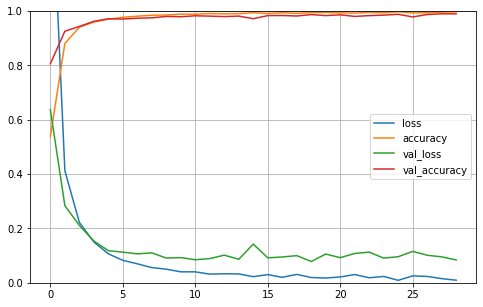

In [9]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [10]:
# Testing accuracy on the reserved test set
test = pd.read_csv(input_path + "/Test.csv")

labels = test["ClassId"].values
test_imgs = test["Path"].values

(1, 32, 32, 3)
11


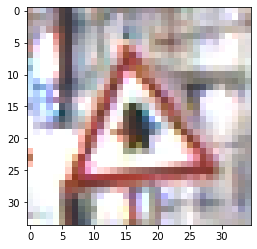

In [11]:
# How an image looks like
img_index = 25
image = Image.open(input_path + test_imgs[img_index])
img = image.resize((height,width))
img = np.array(img) / 255.
img = img.reshape(1, height, width, channels)

print(img.shape)
print(labels[img_index])
plt.imshow(image)

In [12]:
# Dictionary to map classes.
classes = { 
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)', 
    2:'Speed limit (50km/h)', 
    3:'Speed limit (60km/h)', 
    4:'Speed limit (70km/h)', 
    5:'Speed limit (80km/h)', 
    6:'End of speed limit (80km/h)', 
    7:'Speed limit (100km/h)', 
    8:'Speed limit (120km/h)', 
    9:'No passing', 
    10:'No passing veh over 3.5 tons', 
    11:'Right-of-way at intersection', 
    12:'Priority road', 
    13:'Yield', 
    14:'Stop', 
    15:'No vehicles', 
    16:'Veh > 3.5 tons prohibited', 
    17:'No entry', 
    18:'General caution', 
    19:'Dangerous curve left', 
    20:'Dangerous curve right', 
    21:'Double curve', 
    22:'Bumpy road', 
    23:'Slippery road', 
    24:'Road narrows on the right', 
    25:'Road work', 
    26:'Traffic signals', 
    27:'Pedestrians', 
    28:'Children crossing', 
    29:'Bicycles crossing', 
    30:'Beware of ice/snow',
    31:'Wild animals crossing', 
    32:'End speed + passing limits', 
    33:'Turn right ahead', 
    34:'Turn left ahead', 
    35:'Ahead only', 
    36:'Go straight or right', 
    37:'Go straight or left', 
    38:'Keep right', 
    39:'Keep left', 
    40:'Roundabout mandatory', 
    41:'End of no passing', 
    42:'End no passing veh > 3.5 tons'
          }

In [13]:
# Prediction of this image
pred = model.predict(img)[0]
pred=(np.argmax(pred))
print(pred)

sign = classes[pred]
print(sign)

11
Right-of-way at intersection


In [14]:
# Load and preprocess test set
test = pd.read_csv(input_path + 'Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data = []

for img in imgs:
    try:
        image = cv2.imread(input_path + img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((height, width))
        data.append(np.array(resize_image))
    except:
        print("Error")
        
X_test = np.array(data)
X_test = X_test / 255

In [17]:
# Prediction of test set
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
print(accuracy_score(labels, pred))

0.9431512272367379


In [16]:
model.save("./model.h5")